# Controversy

Hard controversy defined as:
$$H = \frac{1}{c_H} \left[ \sum_{i=0.5}^5 p_i(r_i - \bar{r})^2 \right]^{\frac{1}{2}}$$

Soft controversy defined as:
$$S = 1 - \frac{1}{c_S} \left[ \sum_{i=0.5}^5(p_i - 0.1)^2 \right]^ \frac{1}{2}$$

where $p_i$ is the proportion of ratings for that particular rating (e.g. 3.5) for that movie. $c_H$ and $c_S$ are the respective maximum values for hard and soft controversy, so that they are normalized to between 0 and 1.

In general, as we can see below in the regressions, hard controversy seems to be susceptible to being overfit, and should be the primary metric of choice.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
movies = pd.read_csv('movie_lense/movie_lense/movies.csv')
ratings = pd.read_csv('movie_lense/movie_lense/ratings.csv')
links = pd.read_csv('movie_lense/movie_lense/links.csv')
tags = pd.read_csv('movie_lense/movie_lense/tags.csv')
genome_tags = pd.read_csv('movie_lense/movie_lense/genome-tags.csv')
genome_scores = pd.read_csv('movie_lense/movie_lense/genome-scores.csv')
movie_industry = pd.read_csv('movie_industry.csv', encoding='latin-1')
the_oscar_award = pd.read_csv('the_oscar_award.csv')

In [3]:
movie_ratings_total = movies.merge(ratings, on='movieId', how='left')

In [4]:
movie_ratings = movie_ratings_total[movie_ratings_total.groupby('movieId')['rating'].transform('count') > 30].copy()
movie_ratings['count_bucket'] = np.where(movie_ratings.groupby('movieId')['rating'].transform('count') > 5000, '> 5000', '<= 100')
movie_ratings['avg_rating'] = movie_ratings.groupby('movieId')['rating'].transform('mean')
movie_ratings['v'] = movie_ratings.groupby(['movieId', 'rating'])['rating'].transform('count')
movie_ratings['N'] = movie_ratings.groupby('movieId')['rating'].transform('count')
movie_ratings['p'] = movie_ratings['v'] / movie_ratings['N']
movie_ratings['hard_controversy'] = (movie_ratings['rating'] - movie_ratings['avg_rating']).pow(2) * movie_ratings['p']
movie_ratings['soft_controversy'] = (movie_ratings['p'] - 0.1).pow(2)
movie_ratings

,movieId,title,genres,userId,rating,timestamp,count_bucket,avg_rating,v,N,p,hard_controversy,soft_controversy
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,4.0,1.113766e+09,> 5000,3.886649,22710,68469,0.331683,0.004262,0.053677
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10.0,5.0,9.488858e+08,> 5000,3.886649,16497,68469,0.240941,0.298658,0.019864
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,14.0,4.5,1.442169e+09,> 5000,3.886649,5684,68469,0.083016,0.031230,0.000288
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,4.0,1.370810e+09,> 5000,3.886649,22710,68469,0.331683,0.004262,0.053677
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,22.0,4.0,1.237623e+09,> 5000,3.886649,22710,68469,0.331683,0.004262,0.053677
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27756667,192307,The Meg (2018),Action|Horror|Sci-Fi|Thriller,270572.0,3.0,1.537208e+09,<= 100,2.951220,27,82,0.329268,0.000784,0.052564
27756668,192307,The Meg (2018),Action|Horror|Sci-Fi|Thriller,272459.0,5.0,1.534056e+09,<= 100,2.951220,7,82,0.085366,0.358323,0.000214
27756669,192307,The Meg (2018),Action|Horror|Sci-Fi|Thriller,275841.0,1.5,1.533875e+09,<= 100,2.951220,1,82,0.012195,0.025683,0.007710
27756670,192307,The Meg (2018),Action|Horror|Sci-Fi|Thriller,279522.0,3.0,1.536930e+09,<= 100,2.951220,27,82,0.329268,0.000784,0.052564


In [5]:
H = movie_ratings.groupby(['movieId', 'rating'])['hard_controversy'].mean().sum(level=0).pow(0.5) / 2.25

In [6]:
S = 1 - movie_ratings.groupby(['movieId', 'rating'])['soft_controversy'].mean().sum(level=0).pow(0.5) / np.sqrt(0.9)

In [7]:
larger_H = movie_ratings[movie_ratings['count_bucket'] == '> 5000'].groupby(['movieId', 'rating'])['hard_controversy'].mean().sum(level=0).pow(0.5) / 2
larger_S = 1 - movie_ratings[movie_ratings['count_bucket'] == '> 5000'].groupby(['movieId', 'rating'])['soft_controversy'].mean().sum(level=0).pow(0.5) / np.sqrt(0.9)
smaller_H = movie_ratings[movie_ratings['count_bucket'] != '> 5000'].groupby(['movieId', 'rating'])['hard_controversy'].mean().sum(level=0).pow(0.5) / 2
smaller_S = 1 - movie_ratings[movie_ratings['count_bucket'] != '> 5000'].groupby(['movieId', 'rating'])['soft_controversy'].mean().sum(level=0).pow(0.5) / np.sqrt(0.9)

In [8]:
sample_H = pd.DataFrame(H)
sample_H['controversial_0.638_thresh'] = sample_H['hard_controversy'] > 0.638
sample_H['controversial_0.5_thresh'] = sample_H['hard_controversy'] > 0.5

In [9]:
sample_H.to_csv('hard_controversy_cutoffs')

In [10]:
sample_H['controversial_0.5_thresh'].describe()

count     15751
unique        2
top       False
freq      13145
Name: controversial_0.5_thresh, dtype: object

c:\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings

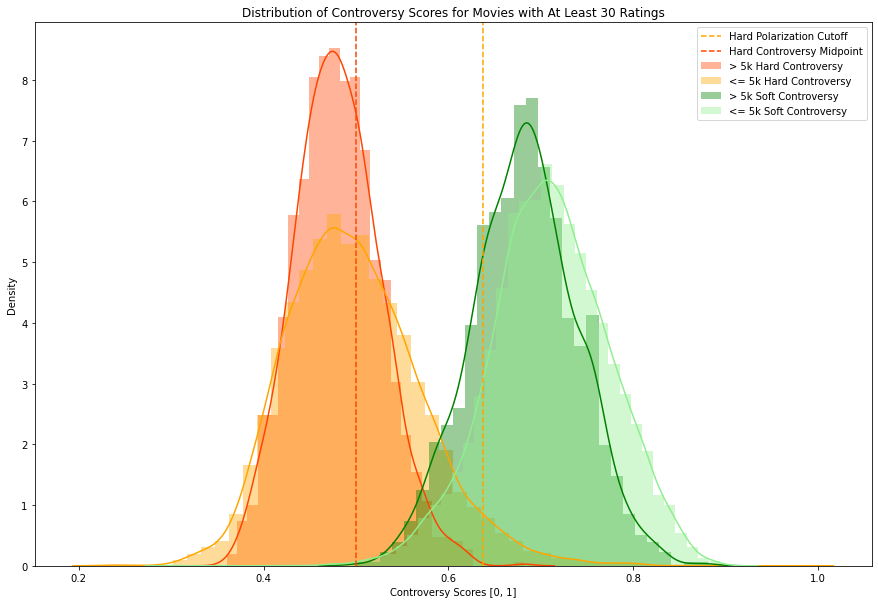

In [11]:
plt.figure(figsize=(15, 10))
colors = ['orangered', 'orange', 'green', 'lightgreen']
for i, (name, plot_thing) in enumerate(zip(['> 5k Hard Controversy', '<= 5k Hard Controversy', 
                                            '> 5k Soft Controversy', '<= 5k Soft Controversy'], 
                                           [larger_H, smaller_H, larger_S, smaller_S])):
    sns.distplot(plot_thing, label=name, color=colors[i])
plt.xlabel('Controversy Scores [0, 1]')
plt.title('Distribution of Controversy Scores for Movies with At Least 30 Ratings')
plt.axvline(0.638, label='Hard Polarization Cutoff', linestyle='--', color='orange')
plt.axvline(0.5, label='Hard Controversy Midpoint', linestyle='--', color='orangered')
plt.ylabel('Density')
plt.legend()
plt.show()

c:\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


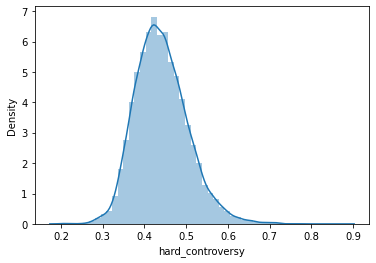

In [12]:
sns.distplot(H)

c:\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


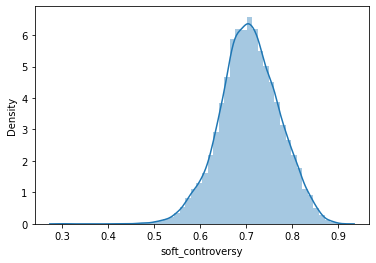

In [13]:
sns.distplot(S)

## Linear Regressions
Input is tag relevancy scores, output is controversy scores

Generate matrix of relevances on tags:

To be used as inputs

In [14]:
relevance_to_rating_df = movies.join(genome_scores.set_index("movieId"), how = "inner", on = "movieId")
relevance_matrix_df = relevance_to_rating_df.set_index(["movieId","tagId"])["relevance"].unstack()
relevance_to_rating_df = relevance_matrix_df.join(H, how="inner", on="movieId").join(S, how="inner", on="movieId")
relevance_to_rating_df

,1,2,3,4,5,6,7,8,9,10,...,1121,1122,1123,1124,1125,1126,1127,1128,hard_controversy,soft_controversy
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02900,0.02375,0.05425,0.06875,0.16000,0.19525,0.07600,0.25200,0.22750,0.02400,...,0.04075,0.03175,0.12950,0.04550,0.02000,0.03850,0.09125,0.02225,0.413131,0.642883
2,0.03625,0.03625,0.08275,0.08175,0.10200,0.06900,0.05775,0.10100,0.08225,0.05250,...,0.01650,0.02450,0.13050,0.02700,0.01825,0.01225,0.09925,0.01850,0.426437,0.679760
3,0.04150,0.04950,0.03000,0.09525,0.04525,0.05925,0.04000,0.14150,0.04075,0.03200,...,0.03550,0.02125,0.12775,0.03250,0.01625,0.02125,0.09525,0.01750,0.450977,0.611081
4,0.03350,0.03675,0.04275,0.02625,0.05250,0.03025,0.02425,0.07475,0.03750,0.02400,...,0.02125,0.03675,0.15925,0.05225,0.01500,0.01600,0.09175,0.01500,0.493950,0.624006
5,0.04050,0.05175,0.03600,0.04625,0.05500,0.08000,0.02150,0.07375,0.02825,0.02375,...,0.02050,0.02125,0.17725,0.02050,0.01500,0.01550,0.08875,0.01575,0.442776,0.594331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185435,0.10625,0.10775,0.03025,0.05650,0.23175,0.04575,0.05175,0.44700,0.19875,0.04025,...,0.03500,0.12125,0.32200,0.08200,0.03325,0.02425,0.13725,0.02625,0.472222,0.729648
185585,0.04250,0.04175,0.06475,0.07625,0.08500,0.03800,0.03425,0.16850,0.02525,0.03525,...,0.03050,0.02750,0.21850,0.04525,0.03550,0.02550,0.17475,0.03100,0.443729,0.769825
186587,0.08950,0.09125,0.05075,0.04900,0.19475,0.04500,0.03125,0.17275,0.07850,0.02475,...,0.04000,0.01975,0.22075,0.15125,0.06150,0.04300,0.20800,0.03925,0.394023,0.697246


### Hard Controversy Regressions

In [15]:
def compute_LR_MSE(X, y, model):
    m, n = X.shape
    y_hat = model.predict(X) 
    MSE = (y_hat - y).dot(y_hat - y)/m
    return MSE

In [16]:
from sklearn.linear_model import LinearRegression
X_relevance_to_rating = relevance_to_rating_df.iloc[:,:-2].to_numpy()
y_relevance_to_rating = relevance_to_rating_df.iloc[:,-2].to_numpy()
model = LinearRegression().fit(X_relevance_to_rating, y_relevance_to_rating)
r_sq = model.score(X_relevance_to_rating, y_relevance_to_rating)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('coefficients:', model.coef_)

coefficient of determination: 0.6387150035172606
intercept: 0.4845814217103576
coefficients: [ 0.01687121  0.00955071  0.00865724 ... -0.0014202   0.00053986
 -0.00155013]


In [19]:
import statsmodels.api as sm
LR_model = sm.OLS(y_relevance_to_rating, sm.add_constant(X_relevance_to_rating))
LR_results = LR_model.fit()
# LR_results.summary()

In [20]:
compute_LR_MSE(sm.add_constant(X_relevance_to_rating), y_relevance_to_rating, LR_results)

0.0012157935525465753

Check which tags are most associated 

In [21]:
def results_summary_to_dataframe(results):
    """return dataframe from statsmodels summary result"""
    pvals = results.pvalues
    coeff = results.params

    results_df = pd.DataFrame({"pvals":pvals,
                                "coeff":coeff
                                })
    
    return results_df[["coeff","pvals"]]

In [22]:
summary_df = results_summary_to_dataframe(LR_results)

c:\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


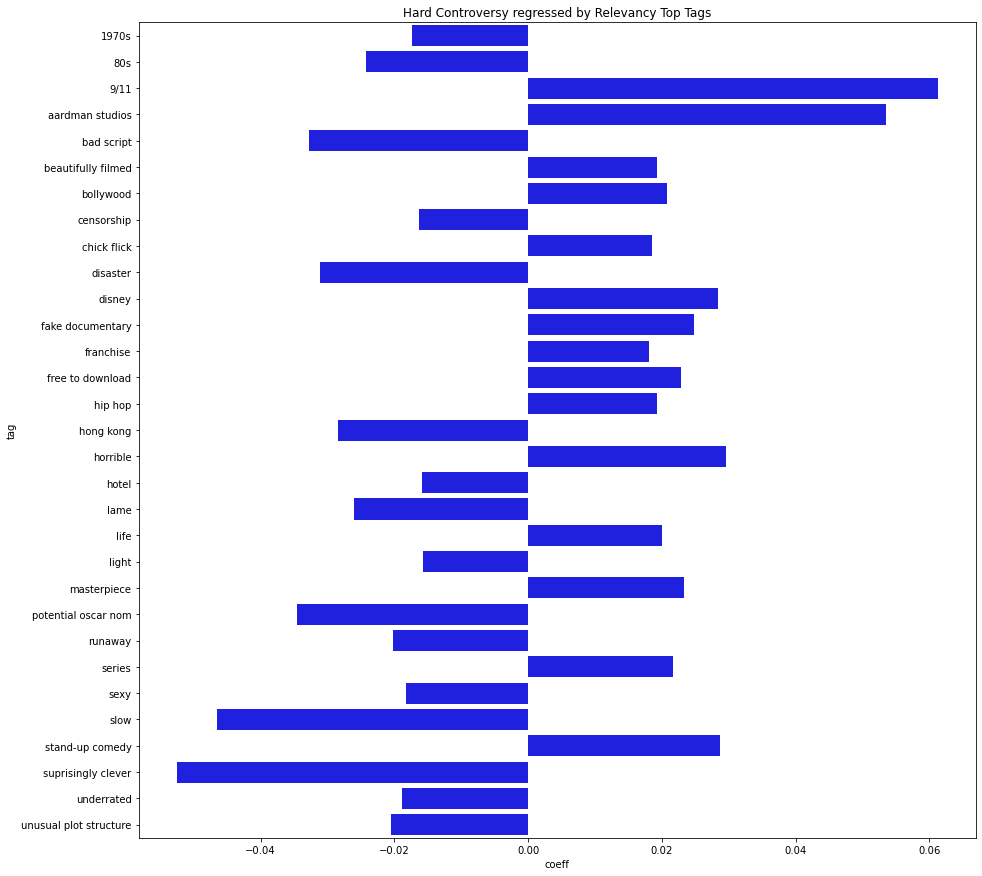

In [23]:
top_tags = genome_tags.join(summary_df[summary_df['pvals'] < 0.0001], how='inner', on='tagId')
plt.figure(figsize=(15, 15))
sns.barplot(top_tags['coeff'], top_tags['tag'],color='blue', orient='h')
plt.title('Hard Controversy regressed by Relevancy Top Tags')
plt.show()

### Soft Controversy Regressions

In [24]:
from sklearn.linear_model import LinearRegression
X_relevance_to_rating = relevance_to_rating_df.iloc[:,:-2].to_numpy()
y_relevance_to_rating = relevance_to_rating_df.iloc[:,-1].to_numpy()
model = LinearRegression().fit(X_relevance_to_rating, y_relevance_to_rating)
r_sq = model.score(X_relevance_to_rating, y_relevance_to_rating)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('coefficients:', model.coef_)

coefficient of determination: 0.5862423171354008
intercept: 0.8029717177377139
coefficients: [ 0.00693094 -0.02210131 -0.00258926 ... -0.00062204 -0.00589878
  0.01604236]


In [25]:
import statsmodels.api as sm
LR_model = sm.OLS(y_relevance_to_rating, sm.add_constant(X_relevance_to_rating))
LR_results = LR_model.fit()
# LR_results.summary()

In [26]:
compute_LR_MSE(sm.add_constant(X_relevance_to_rating), y_relevance_to_rating, LR_results)

0.0016860991065813468

In [27]:
summary_df = results_summary_to_dataframe(LR_results)

c:\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


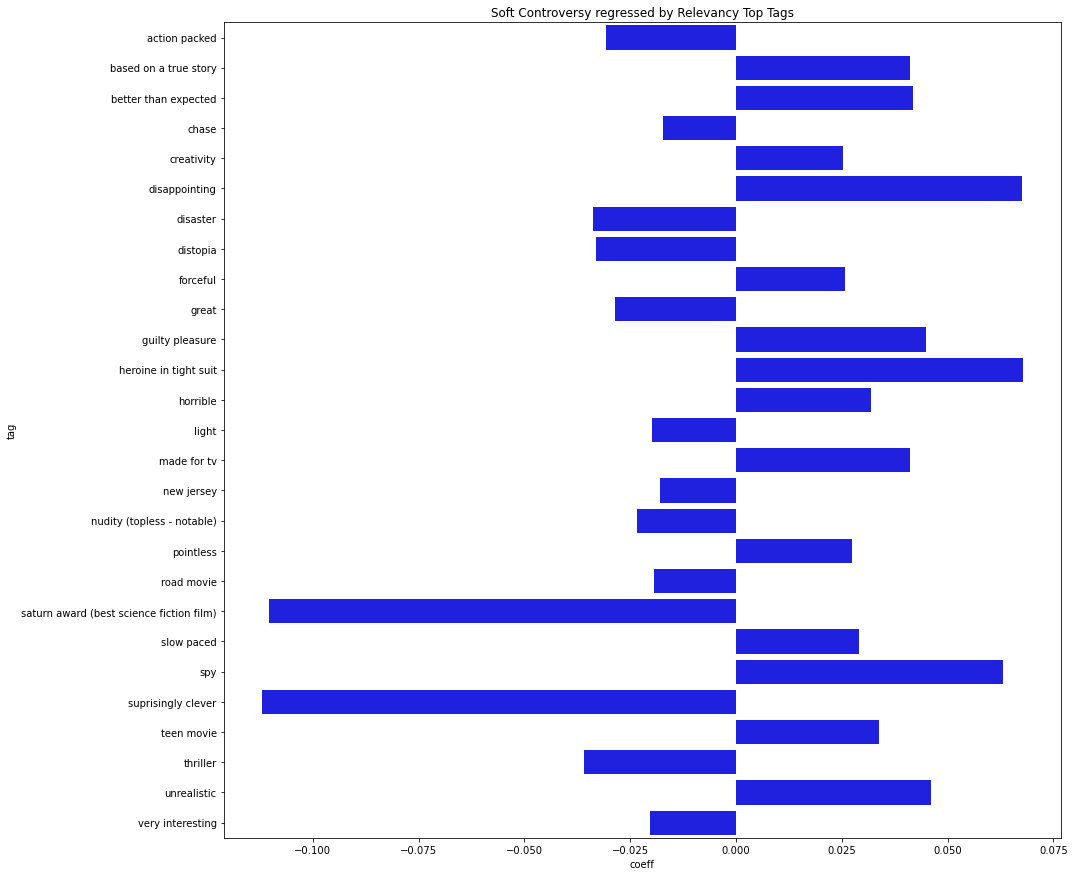

In [28]:
top_tags = genome_tags.join(summary_df[summary_df['pvals'] < 0.0001], how='inner', on='tagId')
plt.figure(figsize=(15, 15))
sns.barplot(top_tags['coeff'], top_tags['tag'],color='blue', orient='h')
plt.title('Soft Controversy regressed by Relevancy Top Tags')
plt.show()

## Train/Test and LASSO - Reducing Overfitting

In [29]:
m,n = relevance_to_rating_df.shape
relevance_to_rating_tr, relevance_to_rating_cv, relevance_to_rating_ts = np.split(relevance_to_rating_df.sample(frac=1).to_numpy(), [int(.6 * m), int(.8 * m)])
print("training set shape", relevance_to_rating_tr.shape)
print("cross validation set shape", relevance_to_rating_cv.shape)
print("test set shape", relevance_to_rating_ts.shape)

training set shape (7905, 1130)
cross validation set shape (2635, 1130)
test set shape (2636, 1130)


In [30]:
X_relevance_to_rating_tr = relevance_to_rating_tr[:,:-2]
y_relevance_to_rating_tr = relevance_to_rating_tr[:,-2]

LR_model = sm.OLS(y_relevance_to_rating_tr, sm.add_constant(X_relevance_to_rating_tr))
LR_results = LR_model.fit()
print("coefficients:", LR_results.params)

coefficients: [ 0.4911162   0.00430971  0.0070757  ... -0.01578924  0.01371068
 -0.00609437]


Compute MSE

In [31]:
X_relevance_to_rating_ts = relevance_to_rating_ts[:,:-2]
y_relevance_to_rating_ts = relevance_to_rating_ts[:,-2]
X_relevance_to_rating_cv = relevance_to_rating_cv[:,:-2]
y_relevance_to_rating_cv = relevance_to_rating_cv[:,-2]
LR_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_tr), y_relevance_to_rating_tr, LR_results)
LR_MSE_ts = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_ts), y_relevance_to_rating_ts, LR_results)
LR_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_cv), y_relevance_to_rating_cv, LR_results)
print("Training MSE:", LR_MSE_tr)
print("Testing MSE:", LR_MSE_ts)
print("Cross validation MSE:", LR_MSE_cv)

Training MSE: 0.0011462544326129984
Testing MSE: 0.001541525155329503
Cross validation MSE: 0.0016420711790213222


#### Introducing Regularization

In [32]:
LR_reg_model = sm.OLS(y_relevance_to_rating_tr, sm.add_constant(X_relevance_to_rating_tr))
alpha = 1
Alpha = np.ones(X_relevance_to_rating_tr.shape[1]+1 ) * alpha
Alpha[0] = 0
LR_reg_results = LR_reg_model.fit_regularized(alpha = Alpha, L1_wt = 0)
print("coefficients:", LR_reg_results.params)

coefficients: [ 4.80049873e-01 -1.70149403e-04 -1.25007156e-04 ... -4.06153251e-04
  4.21094571e-04  1.02963473e-04]


In [33]:
LR_reg_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_tr), y_relevance_to_rating_tr, LR_reg_results)
LR_reg_MSE_ts = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_ts), y_relevance_to_rating_ts, LR_reg_results)
LR_reg_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_cv), y_relevance_to_rating_cv, LR_reg_results)
print("Training MSE:", LR_reg_MSE_tr)
print("Cross validation MSE:", LR_reg_MSE_cv)
print("Test MSE:", LR_reg_MSE_ts)

Training MSE: 0.002292982596277446
Cross validation MSE: 0.002243845961425503
Test MSE: 0.0021952191659168714


#### Tuning Alpha

In [34]:
for alpha in [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]:
    Alpha = np.ones(X_relevance_to_rating_tr.shape[1]+1 ) * alpha
    Alpha[0] = 0 # do not penalize the constant coefficient
    LR_reg_results = LR_reg_model.fit_regularized(alpha = Alpha, L1_wt = 0)
    LR_reg_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_tr), y_relevance_to_rating_tr, LR_reg_results)
    LR_reg_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_cv), y_relevance_to_rating_cv, LR_reg_results)
    print("When alpha =", alpha)
    print("Training MSE:", LR_reg_MSE_tr)
    print("Cross validation MSE:", LR_reg_MSE_cv)

When alpha = 0
Training MSE: 0.0011462544326129984
Cross validation MSE: 0.0016420711790213244
When alpha = 0.0001
Training MSE: 0.0011481613697940523
Cross validation MSE: 0.001608403324601237
When alpha = 0.0003
Training MSE: 0.0011564273465607612
Cross validation MSE: 0.001566870244242208
When alpha = 0.001
Training MSE: 0.0011898817447887503
Cross validation MSE: 0.001506906348507742
When alpha = 0.003
Training MSE: 0.0012621040020586295
Cross validation MSE: 0.0014738241010775574
When alpha = 0.01
Training MSE: 0.0013943870159657133
Cross validation MSE: 0.0014995168458449008
When alpha = 0.03
Training MSE: 0.001553789506161108
Cross validation MSE: 0.0015882557172248522
When alpha = 0.1
Training MSE: 0.0017604133325045995
Cross validation MSE: 0.0017473159494262485
When alpha = 0.3
Training MSE: 0.001986858932163357
Cross validation MSE: 0.0019498080987500601
When alpha = 1
Training MSE: 0.002292982596277446
Cross validation MSE: 0.002243845961425503


In [35]:
alpha = 0.0003
Alpha = np.ones(X_relevance_to_rating_tr.shape[1]+1 ) * alpha
Alpha[0] = 0 # do not penalize the constant coefficient
LR_reg_results = LR_reg_model.fit_regularized(alpha = Alpha, L1_wt = 0)
LR_reg_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_tr), y_relevance_to_rating_tr, LR_reg_results)
LR_reg_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_cv), y_relevance_to_rating_cv, LR_reg_results)
LR_reg_MSE_ts = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_ts), y_relevance_to_rating_ts, LR_reg_results)
print("When alpha =", alpha)
print("Training MSE:", LR_reg_MSE_tr)
print("Cross validation MSE:", LR_reg_MSE_cv)
print("Test MSE:", LR_reg_MSE_ts)

When alpha = 0.0003
Training MSE: 0.0011564273465607612
Cross validation MSE: 0.001566870244242208
Test MSE: 0.001468380496949847


In [36]:
reg_summary_df = pd.DataFrame(LR_reg_results.params, columns=['coefficient'])
reg_summary_df['magnitude'] = reg_summary_df['coefficient'].abs()


c:\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


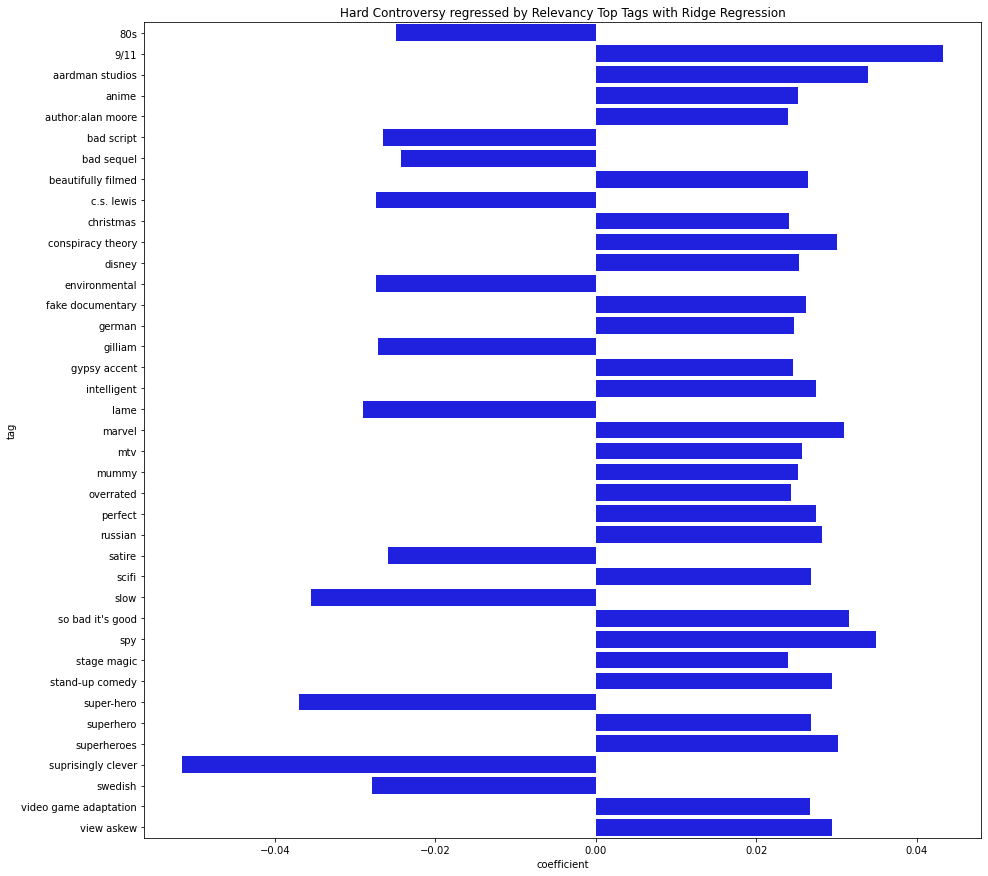

In [37]:
top_tags = genome_tags.join(reg_summary_df.nlargest(40, 'magnitude'), how='inner', on='tagId')
plt.figure(figsize=(15, 15))
sns.barplot(top_tags['coefficient'], top_tags['tag'],color='blue', orient='h')
plt.title('Hard Controversy regressed by Relevancy Top Tags with Ridge Regression')
plt.show()

## Repeat for Soft Controversy (seems very overfit)

In [38]:
X_relevance_to_rating_tr = relevance_to_rating_tr[:,:-2]
y_relevance_to_rating_tr = relevance_to_rating_tr[:,-1]

LR_model = sm.OLS(y_relevance_to_rating_tr, sm.add_constant(X_relevance_to_rating_tr))
LR_results = LR_model.fit()
print("coefficients:", LR_results.params)

coefficients: [ 8.17515262e-01 -1.78943216e-02 -1.57403991e-02 ... -4.37840446e-04
 -1.07723543e-04  2.44967286e-02]


In [39]:
LR_reg_model = sm.OLS(y_relevance_to_rating_tr, sm.add_constant(X_relevance_to_rating_tr))
alpha = 1
Alpha = np.ones(X_relevance_to_rating_tr.shape[1]+1 ) * alpha
Alpha[0] = 0
LR_reg_results = LR_reg_model.fit_regularized(alpha = Alpha, L1_wt = 0)
print("coefficients:", LR_reg_results.params)

coefficients: [ 7.33034691e-01 -8.50569165e-05 -1.33022503e-04 ... -3.07960631e-04
  5.51266280e-04  2.75353312e-04]


#### Tuning Alpha

In [40]:
for alpha in [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]:
    Alpha = np.ones(X_relevance_to_rating_tr.shape[1]+1 ) * alpha
    Alpha[0] = 0 # do not penalize the constant coefficient
    LR_reg_results = LR_reg_model.fit_regularized(alpha = Alpha, L1_wt = 0)
    LR_reg_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_tr), y_relevance_to_rating_tr, LR_reg_results)
    LR_reg_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_cv), y_relevance_to_rating_cv, LR_reg_results)
    print("When alpha =", alpha)
    print("Training MSE:", LR_reg_MSE_tr)
    print("Cross validation MSE:", LR_reg_MSE_cv)

When alpha = 0
Training MSE: 0.0015622802656071872
Cross validation MSE: 0.07366054428222318
When alpha = 0.0001
Training MSE: 0.001565637794485264
Cross validation MSE: 0.07356537015131008
When alpha = 0.0003
Training MSE: 0.0015790837596916414
Cross validation MSE: 0.07343997008036308
When alpha = 0.001
Training MSE: 0.0016279215335212435
Cross validation MSE: 0.07320874286092048
When alpha = 0.003
Training MSE: 0.0017269341571503514
Cross validation MSE: 0.07294721518171898
When alpha = 0.01
Training MSE: 0.0019117359304807076
Cross validation MSE: 0.07269884864572135
When alpha = 0.03
Training MSE: 0.0021472519151002505
Cross validation MSE: 0.0725849752084224
When alpha = 0.1
Training MSE: 0.002441621738486999
Cross validation MSE: 0.07259106824216348
When alpha = 0.3
Training MSE: 0.0027134214959130313
Cross validation MSE: 0.0726970668011565
When alpha = 1
Training MSE: 0.0030305754190210602
Cross validation MSE: 0.07291958255605763


In [41]:
alpha = 0.0003
Alpha = np.ones(X_relevance_to_rating_tr.shape[1]+1 ) * alpha
Alpha[0] = 0 # do not penalize the constant coefficient
LR_reg_results = LR_reg_model.fit_regularized(alpha = Alpha, L1_wt = 0)
LR_reg_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_tr), y_relevance_to_rating_tr, LR_reg_results)
LR_reg_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_cv), y_relevance_to_rating_cv, LR_reg_results)
LR_reg_MSE_ts = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_ts), y_relevance_to_rating_ts, LR_reg_results)
print("When alpha =", alpha)
print("Training MSE:", LR_reg_MSE_tr)
print("Cross validation MSE:", LR_reg_MSE_cv)
print("Test MSE:", LR_reg_MSE_ts)

When alpha = 0.0003
Training MSE: 0.0015790837596916414
Cross validation MSE: 0.07343997008036308
Test MSE: 0.07265383736412678


In [42]:
reg_summary_df = pd.DataFrame(LR_reg_results.params, columns=['coefficient'])
reg_summary_df['magnitude'] = reg_summary_df['coefficient'].abs()


c:\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


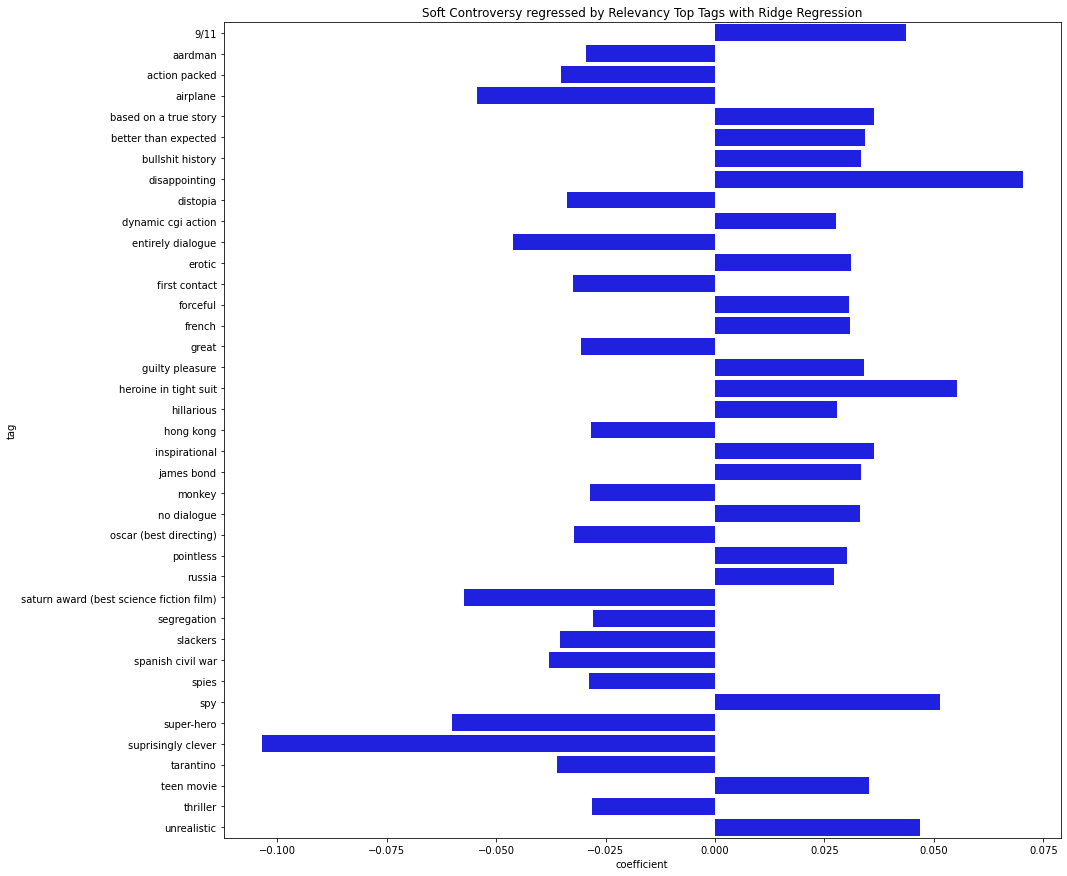

In [43]:
top_tags = genome_tags.join(reg_summary_df.nlargest(40, 'magnitude'), how='inner', on='tagId')
plt.figure(figsize=(15, 15))
sns.barplot(top_tags['coefficient'], top_tags['tag'],color='blue', orient='h')
plt.title('Soft Controversy regressed by Relevancy Top Tags with Ridge Regression')
plt.show()

## Finding correlations between tags to reduce feature space

In [44]:
relevance_corr_df = relevance_matrix_df.corr()
relevance_corr_df

tagId,1,2,3,4,5,6,7,8,9,10,...,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
tagId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.750238,-0.030803,-0.055117,-0.010714,-0.025092,0.169082,-0.002423,0.037608,-0.030121,...,0.044737,0.020648,0.006740,-0.072366,-0.046793,-0.040764,-0.020332,0.011513,-0.026563,-0.029255
2,0.750238,1.000000,-0.019098,-0.038638,0.004226,-0.010537,0.163721,0.002513,0.046954,-0.018468,...,0.033139,0.011203,-0.000700,-0.063766,-0.055521,-0.050397,-0.009879,0.001404,-0.027472,-0.030366
3,-0.030803,-0.019098,1.000000,0.353302,0.256638,0.193530,0.142959,0.097375,-0.004793,0.620194,...,0.067369,0.114708,0.046064,0.094647,-0.042658,0.027473,0.141929,0.046692,-0.081894,-0.015827
4,-0.055117,-0.038638,0.353302,1.000000,0.540420,0.423666,0.243676,0.220936,0.040616,0.394791,...,0.128869,0.186698,0.107791,0.117080,-0.086903,0.020632,0.098091,0.103807,-0.142582,-0.050844
5,-0.010714,0.004226,0.256638,0.540420,1.000000,0.448431,0.251901,0.241134,0.088559,0.304216,...,0.151315,0.250746,0.238796,0.080902,-0.048202,0.043336,0.009830,0.216569,-0.111265,-0.043519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,-0.040764,-0.050397,0.027473,0.020632,0.043336,0.086827,-0.005798,0.101176,0.001051,0.024601,...,0.069868,-0.065284,-0.048983,0.402038,0.643939,1.000000,-0.057903,-0.047726,-0.096522,-0.040045
1125,-0.020332,-0.009879,0.141929,0.098091,0.009830,-0.019271,-0.012248,0.042574,0.004802,0.104903,...,-0.018871,0.003320,-0.014443,0.025242,-0.089879,-0.057903,1.000000,-0.015219,0.007364,0.009714
1126,0.011513,0.001404,0.046692,0.103807,0.216569,0.108880,0.096393,0.101559,0.013886,0.055829,...,0.200383,0.739921,0.950473,-0.002277,-0.117576,-0.047726,-0.015219,1.000000,-0.073597,-0.024862


In [45]:
m,n = relevance_corr_df.shape
for i in range(m):
    for j in range(i+1,m):
        if abs(relevance_corr_df.iat[i,j])> 0.9:
          #print("tagId: "+ str(i+1) +"and tagId: " + str(j+1) + "has correlation " + str(relevance_corr_df.iat[i,j]))
          print("tag <"+ genome_tags.at[i,"tag"] +"> #" +str(i+1)  + " and tag <" + genome_tags.at[j,"tag"] + ">#" + str(j+1) + " has correlation " + str(relevance_corr_df.iat[i,j]))

tag <alien> #43 and tag <aliens>#45 has correlation 0.9480167506065734
tag <animated> #63 and tag <animation>#64 has correlation 0.935088911935152
tag <based on a comic> #108 and tag <based on comic>#114 has correlation 0.9195705740465725
tag <based on a true story> #110 and tag <based on true story>#115 has correlation 0.9134543118654201
tag <based on a true story> #110 and tag <true story>#1047 has correlation 0.9224521267408721
tag <book> #152 and tag <book was better>#153 has correlation 0.9013065033122879
tag <comedy> #230 and tag <funny>#417 has correlation 0.9030930375067381
tag <cute> #278 and tag <cute!>#279 has correlation 0.9089014438452941
tag <dance> #283 and tag <dancing>#284 has correlation 0.900814394204044
tag <feel good movie> #387 and tag <feel-good>#388 has correlation 0.9528472821937137
tag <history> #509 and tag <us history>#1065 has correlation 0.9224942767271389
tag <japan> #575 and tag <japanese>#576 has correlation 0.9086684784196961
tag <kung fu> #592 and tag

#### Reduce the number of features based on correlation

In [46]:
relevance_to_rating_df

,1,2,3,4,5,6,7,8,9,10,...,1121,1122,1123,1124,1125,1126,1127,1128,hard_controversy,soft_controversy
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02900,0.02375,0.05425,0.06875,0.16000,0.19525,0.07600,0.25200,0.22750,0.02400,...,0.04075,0.03175,0.12950,0.04550,0.02000,0.03850,0.09125,0.02225,0.413131,0.642883
2,0.03625,0.03625,0.08275,0.08175,0.10200,0.06900,0.05775,0.10100,0.08225,0.05250,...,0.01650,0.02450,0.13050,0.02700,0.01825,0.01225,0.09925,0.01850,0.426437,0.679760
3,0.04150,0.04950,0.03000,0.09525,0.04525,0.05925,0.04000,0.14150,0.04075,0.03200,...,0.03550,0.02125,0.12775,0.03250,0.01625,0.02125,0.09525,0.01750,0.450977,0.611081
4,0.03350,0.03675,0.04275,0.02625,0.05250,0.03025,0.02425,0.07475,0.03750,0.02400,...,0.02125,0.03675,0.15925,0.05225,0.01500,0.01600,0.09175,0.01500,0.493950,0.624006
5,0.04050,0.05175,0.03600,0.04625,0.05500,0.08000,0.02150,0.07375,0.02825,0.02375,...,0.02050,0.02125,0.17725,0.02050,0.01500,0.01550,0.08875,0.01575,0.442776,0.594331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185435,0.10625,0.10775,0.03025,0.05650,0.23175,0.04575,0.05175,0.44700,0.19875,0.04025,...,0.03500,0.12125,0.32200,0.08200,0.03325,0.02425,0.13725,0.02625,0.472222,0.729648
185585,0.04250,0.04175,0.06475,0.07625,0.08500,0.03800,0.03425,0.16850,0.02525,0.03525,...,0.03050,0.02750,0.21850,0.04525,0.03550,0.02550,0.17475,0.03100,0.443729,0.769825
186587,0.08950,0.09125,0.05075,0.04900,0.19475,0.04500,0.03125,0.17275,0.07850,0.02475,...,0.04000,0.01975,0.22075,0.15125,0.06150,0.04300,0.20800,0.03925,0.394023,0.697246


In [47]:
Cutoff = np.arange(0.3, 0.95, 0.025)
for cutoff in Cutoff:
    upper = relevance_corr_df.where(np.triu(np.ones(relevance_corr_df.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if (any(upper[column] > cutoff) or any(upper[column] < -cutoff))]
    relevance_to_rating_red_df = relevance_to_rating_df.drop(columns = to_drop)
    relevance_to_rating_red_df

    m,n = relevance_to_rating_red_df.shape
    print(m,n)
    relevance_to_rating_red_tr, relevance_to_rating_red_cv, relevance_to_rating_red_ts = np.split(relevance_to_rating_red_df.sample(frac=1, random_state = 200).to_numpy(), [int(.6 * m), int(.8 * m)])
    print("training set shape", relevance_to_rating_red_tr.shape)
    print("cross validation set shape", relevance_to_rating_red_cv.shape)
    print("test set shape", relevance_to_rating_red_ts.shape)
    X_relevance_to_rating_red_tr = relevance_to_rating_red_tr[:,:-2]
    y_relevance_to_rating_red_tr = relevance_to_rating_red_tr[:,-2]
    X_relevance_to_rating_red_cv = relevance_to_rating_red_cv[:,:-2]
    y_relevance_to_rating_red_cv = relevance_to_rating_red_cv[:,-2]
    X_relevance_to_rating_red_ts = relevance_to_rating_red_ts[:,:-2]
    y_relevance_to_rating_red_ts = relevance_to_rating_red_ts[:,-2]
    LR_rel_red_reg_model = sm.OLS(y_relevance_to_rating_red_tr, sm.add_constant(X_relevance_to_rating_red_tr))

    for alpha in [0, 0.0001, 0.0003, 0.001]:
        Alpha = np.ones( X_relevance_to_rating_red_tr.shape[1]+1 ) * alpha
        Alpha[0] = 0 # do not penalize the constant coefficient
        LR_rel_red_reg_results = LR_rel_red_reg_model.fit_regularized(alpha = Alpha, L1_wt = 0)
        LR_rel_red_reg_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_red_tr), y_relevance_to_rating_red_tr, LR_rel_red_reg_results)
        LR_rel_red_reg_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_red_cv), y_relevance_to_rating_red_cv, LR_rel_red_reg_results)
        print("When cutoff, alpha =", cutoff, alpha,)
        print("Training MSE:", LR_rel_red_reg_MSE_tr)
        print("Cross validation MSE:", LR_rel_red_reg_MSE_cv)

13176 105
training set shape (7905, 105)
cross validation set shape (2635, 105)
test set shape (2636, 105)
When cutoff, alpha = 0.3 0
Training MSE: 0.0021563112921636073
Cross validation MSE: 0.0021541930361064156
When cutoff, alpha = 0.3 0.0001
Training MSE: 0.002156756137778927
Cross validation MSE: 0.0021539729181485686
When cutoff, alpha = 0.3 0.0003
Training MSE: 0.002159205930395137
Cross validation MSE: 0.0021557490232895636
When cutoff, alpha = 0.3 0.001
Training MSE: 0.0021729290701532175
Cross validation MSE: 0.002168136275948802
13176 127
training set shape (7905, 127)
cross validation set shape (2635, 127)
test set shape (2636, 127)
When cutoff, alpha = 0.325 0
Training MSE: 0.0019619969952755453
Cross validation MSE: 0.001957035817341832
When cutoff, alpha = 0.325 0.0001
Training MSE: 0.0019625224839929564
Cross validation MSE: 0.001956086352285294
When cutoff, alpha = 0.325 0.0003
Training MSE: 0.0019651060395444704
Cross validation MSE: 0.0019573102483947773
When cutoff,

When cutoff, alpha = 0.6250000000000002 0.001
Training MSE: 0.0013706978114714418
Cross validation MSE: 0.001481722153402443
13176 683
training set shape (7905, 683)
cross validation set shape (2635, 683)
test set shape (2636, 683)
When cutoff, alpha = 0.6500000000000004 0
Training MSE: 0.0013265456674452323
Cross validation MSE: 0.0015200803592392465
When cutoff, alpha = 0.6500000000000004 0.0001
Training MSE: 0.0013274220917986012
Cross validation MSE: 0.0015071159936298176
When cutoff, alpha = 0.6500000000000004 0.0003
Training MSE: 0.0013315442601256019
Cross validation MSE: 0.0014918144024151797
When cutoff, alpha = 0.6500000000000004 0.001
Training MSE: 0.0013498573074840936
Cross validation MSE: 0.0014714091658133291
13176 735
training set shape (7905, 735)
cross validation set shape (2635, 735)
test set shape (2636, 735)
When cutoff, alpha = 0.6750000000000003 0
Training MSE: 0.0012893672725164823
Cross validation MSE: 0.0015024840117600306
When cutoff, alpha = 0.67500000000000

#### Selecting Best Model based on CV: 0.85 cutoff, 0.001 regularization alpha

In [48]:
upper = relevance_corr_df.where(np.triu(np.ones(relevance_corr_df.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if (any(upper[column] > 0.85) or any(upper[column] < -0.85))]
relevance_to_rating_red_df = relevance_to_rating_df.drop(columns = to_drop)

m,n = relevance_to_rating_red_df.shape
print(m,n)
relevance_to_rating_red_tr, relevance_to_rating_red_cv, relevance_to_rating_red_ts = np.split(relevance_to_rating_red_df.sample(frac=1, random_state = 200).to_numpy(), [int(.6 * m), int(.8 * m)])
print("training set shape", relevance_to_rating_red_tr.shape)
print("cross validation set shape", relevance_to_rating_red_cv.shape)
print("test set shape", relevance_to_rating_red_ts.shape)
X_relevance_to_rating_red_tr = relevance_to_rating_red_tr[:,:-2]
y_relevance_to_rating_red_tr = relevance_to_rating_red_tr[:,-2]
X_relevance_to_rating_red_cv = relevance_to_rating_red_cv[:,:-2]
y_relevance_to_rating_red_cv = relevance_to_rating_red_cv[:,-2]
X_relevance_to_rating_red_ts = relevance_to_rating_red_ts[:,:-2]
y_relevance_to_rating_red_ts = relevance_to_rating_red_ts[:,-2]
LR_rel_red_reg_model = sm.OLS(y_relevance_to_rating_red_tr, sm.add_constant(X_relevance_to_rating_red_tr))


Alpha = np.ones( X_relevance_to_rating_red_tr.shape[1]+1 ) * 0.001
Alpha[0] = 0 # do not penalize the constant coefficient
LR_rel_red_reg_results = LR_rel_red_reg_model.fit_regularized(alpha = Alpha, L1_wt = 0)
LR_rel_red_reg_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_red_tr), y_relevance_to_rating_red_tr, LR_rel_red_reg_results)
LR_rel_red_reg_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_red_cv), y_relevance_to_rating_red_cv, LR_rel_red_reg_results)
print("When cutoff, alpha =", 0.85, 0.001,)
print("Training MSE:", LR_rel_red_reg_MSE_tr)
print("Cross validation MSE:", LR_rel_red_reg_MSE_cv)

13176 1060
training set shape (7905, 1060)
cross validation set shape (2635, 1060)
test set shape (2636, 1060)
When cutoff, alpha = 0.85 0.001
Training MSE: 0.0011870942860478819
Cross validation MSE: 0.0013976734608747785


In [49]:
X_relevance_to_rating_red = relevance_to_rating_red_df.values[:,:-2]
y_relevance_to_rating_red = relevance_to_rating_red_df.values[:,-2]
LR_model = sm.OLS(y_relevance_to_rating_red, sm.add_constant(X_relevance_to_rating_red))
LR_red_results = LR_model.fit()
# LR_red_results.summary()


### Simple Model with fewer features
For visual and explanation purposes

In [50]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
Cutoff = [0.5]
m,n = relevance_corr_df.shape
print_details = False
for cutoff in Cutoff:
    upper = relevance_corr_df.where(np.triu(np.ones(relevance_corr_df.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if (any(upper[column] > cutoff) or any(upper[column] < -cutoff))]
    relevance_to_rating_red_df = relevance_to_rating_df.drop(columns = to_drop)
    relevance_to_rating_red_df
    if print_details:
        D=set()
        for i in range(m):
            for j in range(i+1,m):
                if abs(relevance_corr_df.iat[i,j])> cutoff:
                    if j not in D:
                        D.add(j)
                        print("Tag #" +str(j+1)+ " <"+ genome_tags_df.at[j,"tag"] +"> is removed due to correlation(" + str(relevance_corr_df.iat[i,j]) +") with tag #" + str(i+1) + " <" + genome_tags_df.at[i,"tag"] + ">." )
    print("  In total " + str(len(to_drop)) +" tags are removed.")
    m,n = relevance_to_rating_red_df.shape
    i=0
    while i < n-2:
        vif = variance_inflation_factor(relevance_to_rating_red_df.iloc[:,:-2].values, i)
        if vif >5:
            print("Column ", relevance_to_rating_red_df.columns[i], " is droped due to VIF ", vif)
            relevance_to_rating_red_df = relevance_to_rating_red_df.drop(relevance_to_rating_red_df.columns[i], axis=1)
            m,n = relevance_to_rating_red_df.shape
        else:
            i=i+1 
    m,n = relevance_to_rating_red_df.shape
    relevance_to_rating_red_tr, relevance_to_rating_red_cv, relevance_to_rating_red_ts = np.split(relevance_to_rating_red_df.sample(frac=1, random_state = 200).to_numpy(), [int(.6 * m), int(.8 * m)])
    print("training set shape", relevance_to_rating_red_tr.shape)
    print("cross validation set shape", relevance_to_rating_red_cv.shape)
    print("test set shape", relevance_to_rating_red_ts.shape)
    X_relevance_to_rating_red_tr = relevance_to_rating_red_tr[:,:-2]
    y_relevance_to_rating_red_tr = relevance_to_rating_red_tr[:,-2]
    X_relevance_to_rating_red_cv = relevance_to_rating_red_cv[:,:-2]
    y_relevance_to_rating_red_cv = relevance_to_rating_red_cv[:,-2]
    X_relevance_to_rating_red_ts = relevance_to_rating_red_ts[:,:-2]
    y_relevance_to_rating_red_ts = relevance_to_rating_red_ts[:,-2]
    LR_rel_red_reg_model = sm.OLS(y_relevance_to_rating_red_tr, sm.add_constant(X_relevance_to_rating_red_tr))
    for alpha in [0.0003]:
        #Alpha = np.ones( X_relevance_to_rating_red_tr.shape[1]+1 ) * alpha
        #Alpha[0] = 0 # do not penalize the constant coefficient
        LR_rel_red_reg_results = LR_rel_red_reg_model.fit()
        LR_rel_red_reg_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_red_tr), y_relevance_to_rating_red_tr, LR_rel_red_reg_results)
        LR_rel_red_reg_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_red_cv), y_relevance_to_rating_red_cv, LR_rel_red_reg_results)
        print("When cutoff, alpha =", cutoff, ", ", alpha,)
        print("Training MSE:", LR_rel_red_reg_MSE_tr)
        print("Cross validation MSE:", LR_rel_red_reg_MSE_cv, "\n")
    LR_rel_red_reg_results.summary()

  In total 764 tags are removed.
Column  8  is droped due to VIF  6.0395317372551505
Column  18  is droped due to VIF  9.410869484658841
Column  19  is droped due to VIF  10.527630411785598
Column  21  is droped due to VIF  21.14063516273654
Column  29  is droped due to VIF  8.991745793083698
Column  30  is droped due to VIF  10.320285550066771
Column  46  is droped due to VIF  7.964113455048628
Column  49  is droped due to VIF  8.29265312522104
Column  50  is droped due to VIF  5.193862868396601
Column  51  is droped due to VIF  8.67942812636714
Column  52  is droped due to VIF  6.859096280405466
Column  67  is droped due to VIF  5.252518320341315
Column  85  is droped due to VIF  7.143141230060949
Column  99  is droped due to VIF  10.514071397061066
Column  109  is droped due to VIF  6.081255114146381
Column  129  is droped due to VIF  11.97221852691101
Column  145  is droped due to VIF  5.337550154283516
Column  160  is droped due to VIF  5.293269132754612
Column  164  is droped due

In [51]:
(0.00175 - 0.00167) / 0.00167

0.04790419161676646

In [52]:
compute_LR_MSE(sm.add_constant(X_relevance_to_rating_red_tr), y_relevance_to_rating_red_tr, LR_rel_red_reg_results)

0.0016669851968129754

In [53]:
reg_summary_df = pd.DataFrame(LR_rel_red_reg_results.params, columns=['coefficient'])
reg_summary_df['magnitude'] = reg_summary_df['coefficient'].abs()


c:\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


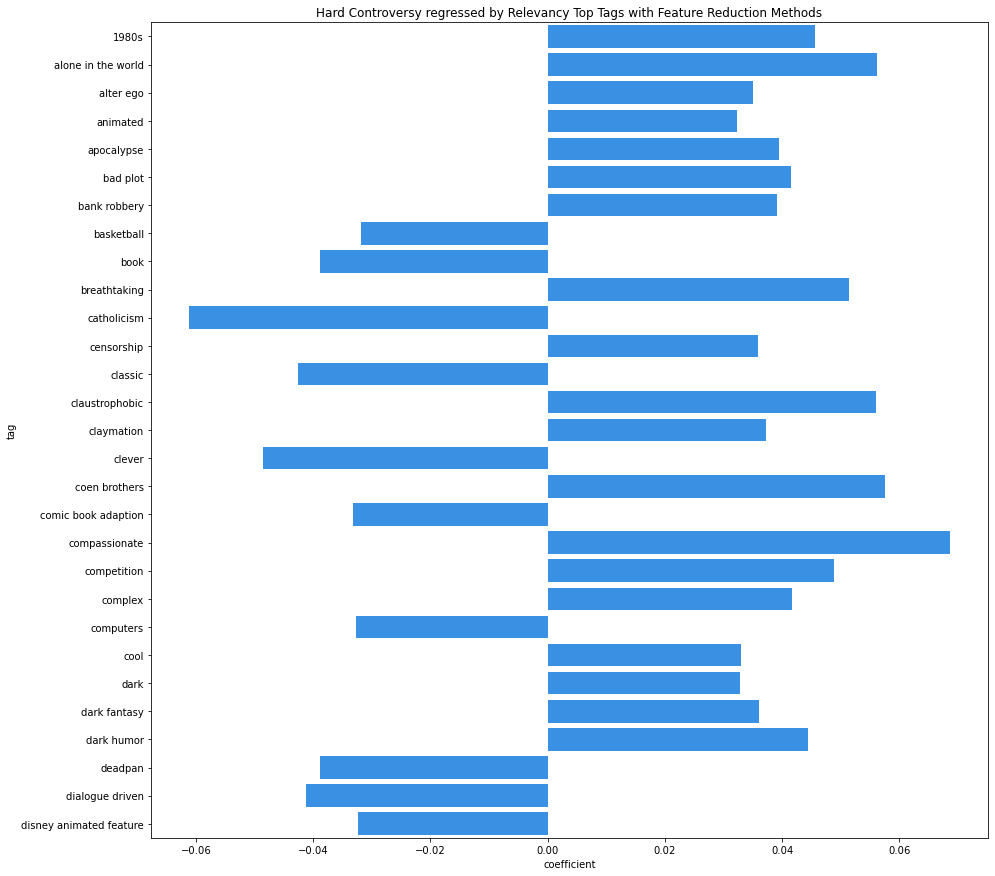

In [54]:
top_tags = genome_tags.join(reg_summary_df.nlargest(30, 'magnitude'), how='inner', on='tagId')
plt.figure(figsize=(15, 15))
sns.barplot(top_tags['coefficient'], top_tags['tag'],color='dodgerblue', orient='h')
plt.title('Hard Controversy regressed by Relevancy Top Tags with Feature Reduction Methods')
plt.show()

#### Hypothesis Testing

Controversy vs. Rating. Seems to be significantly negatively correlated.

NameError: name 'avg_ratings' is not defined

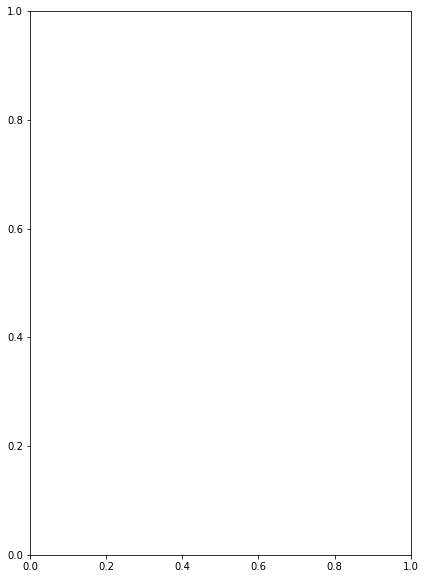

In [55]:
plt.figure(figsize=(15, 10))
plt.title('Controversy Score vs. Average Rating')
plt.subplot(1, 2, 1)
plt.scatter(avg_ratings, H, label='Hard Controversy', color='orange')
plt.legend()
plt.xlabel('Average Movie Rating')
plt.ylabel('Controversy Score')
plt.subplot(1, 2, 2)
plt.scatter(avg_ratings, S, label='Soft Controversy', color='lightgreen')
plt.legend()
plt.xlabel('Average Movie Rating')
plt.show()

In [ ]:
avg_ratings = movie_ratings.groupby('movieId')['rating'].mean()

In [ ]:
LR_model = sm.OLS(avg_ratings, sm.add_constant(H))
controversy_ratings_results = LR_model.fit()
controversy_ratings_results.summary()

In [ ]:
LR_model = sm.OLS(avg_ratings, sm.add_constant(S))
controversy_ratings_results = LR_model.fit()
controversy_ratings_results.summary()

#### Regression on Number of Votes

In [ ]:
num_votes = movie_ratings.groupby('movieId')['rating'].count()

In [ ]:
plt.scatter(num_votes, H)

In [ ]:
LR_model = sm.OLS(num_votes, sm.add_constant(H))
controversy_ratings_results = LR_model.fit()
controversy_ratings_results.summary()

#### Controversy vs. Awards

In [ ]:
movie_H['title'] = movie_H['title'].astype('string')
movie_H

# Appendix

In [ ]:
awards = the_oscar_award[['film', 'winner']].dropna().sort_values('film')
awards['film'] = awards['film'].astype('string')

In [ ]:
movie_H = movies.join(H, on='movieId', how='inner').sort_values('title')
pd.merge_asof(movie_H, 
              awards, 
              left_on='title', 
              right_on='film', 
              direction='nearest')